In [1]:

import ast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold


In [3]:

MODEL = 'paraphrase-mpnet-base-v2'

# Test different values of k
K_VALUES = [1, 3, 5, 7, 10, 15, 20, 30, 40, 50, 75, 100, 125]

df = pd.read_csv('../data/raw/manga.csv')

df = df.drop(['manga_id', 'scored_by', 'status', 'volumes', 'chapters', 'start_date', 'end_date', \
              'members', 'favorites', 'sfw', 'approved', 'created_at_before', 'updated_at', \
              'real_start_date', 'real_end_date', 'serializations', 'main_picture', 'title_english', 'title_japanese', 'title_synonyms'], axis=1)
df.head()

,title,type,score,genres,themes,demographics,authors,synopsis,background,url
0,Berserk,manga,9.47,"['Action', 'Adventure', 'Award Winning', 'Dram...","['Gore', 'Military', 'Mythology', 'Psychologic...",['Seinen'],"[{'id': 1868, 'first_name': 'Kentarou', 'last_...","Guts, a former mercenary now known as the ""Bla...",Berserk won the Award for Excellence at the si...,https://myanimelist.net/manga/2/Berserk
1,One Piece,manga,9.22,"['Action', 'Adventure', 'Fantasy']",[],['Shounen'],"[{'id': 1881, 'first_name': 'Eiichiro', 'last_...","Gol D. Roger, a man referred to as the ""King o...",One Piece is the highest selling manga series ...,https://myanimelist.net/manga/13/One_Piece
2,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,manga,9.30,"['Action', 'Adventure', 'Mystery', 'Supernatur...",['Historical'],"['Seinen', 'Shounen']","[{'id': 2619, 'first_name': 'Hirohiko', 'last_...","In the American Old West, the world's greatest...",JoJo no Kimyou na Bouken Part 7: Steel Ball Ru...,https://myanimelist.net/manga/1706/JoJo_no_Kim...
3,Oyasumi Punpun,manga,9.02,"['Drama', 'Slice of Life']",['Psychological'],['Seinen'],"[{'id': 2836, 'first_name': 'Inio', 'last_name...",Punpun Onodera is a normal 11-year-old boy liv...,Oyasumi Punpun was originally serialized in Yo...,https://myanimelist.net/manga/4632/Oyasumi_Punpun
4,Fullmetal Alchemist,manga,9.03,"['Action', 'Adventure', 'Award Winning', 'Dram...",['Military'],['Shounen'],"[{'id': 1874, 'first_name': 'Hiromu', 'last_na...",Alchemists are knowledgeable and naturally tal...,Hagane no Renkinjutsushi won the 49th Shogakuk...,https://myanimelist.net/manga/25/Fullmetal_Alc...


In [4]:
# Get rid of rows that didn't have a synopsis
df = df.dropna(subset=['synopsis'])

# fill the null'd background info to empty string if null
df['background'] = df['background'].fillna('')

In [5]:
print(df.isnull().sum())

title               0
type                0
score           21787
genres              0
themes              0
demographics        0
authors             0
synopsis            0
background          0
url                 0
dtype: int64


# KNN - K-Fold-Cross-Validation

To find the best K value for KNN, we can use K Fold Cross Validation more robustly by reducing variability

We will also make train and test set to have our KNN perform predictions to see which k is optimal for making predictions amongst our k fold dataset

In [6]:
npz_file = np.load('../data/embeddings/synopsis_embeddings.npz')
embeddings = npz_file['embeddings']

# Extract ratings
ratings = df['score'].values

In [7]:
# Function to predict ratings using a given k
def knn_predict(X_train, y_train, X_val, k):
    similarity_matrix = cosine_similarity(X_val, X_train)
    predictions = []
    for idx, sim_scores in enumerate(similarity_matrix):
        similar_indices = np.argsort(sim_scores)[::-1][:k]
        similar_ratings = y_train[similar_indices]
        similar_scores = sim_scores[similar_indices]
        weighted_average = np.dot(similar_ratings, similar_scores) / similar_scores.sum()
        predictions.append(weighted_average)
    return np.array(predictions)

In [8]:
# Perform K-Fold-Cross-Validation to determine the best 'k'

# Known ratings mask
mask = ~pd.isnull(ratings)

# Data for cross-validation
X = embeddings[mask]
y = ratings[mask]

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

average_errors = []

# Perform k-fold cross-validation for each k
for k in K_VALUES:
    fold_errors = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        y_pred = knn_predict(X_train, y_train, X_val, k)
        fold_error = mean_squared_error(y_val, y_pred)
        fold_errors.append(fold_error)
    
    average_error = np.mean(fold_errors)
    average_errors.append(average_error)
    print(f"k={k}, Average MSE={average_error}")

# Find the best k
best_k = K_VALUES[np.argmin(average_errors)]
print(f"Best k value: {best_k}")

k=1, Average MSE=0.4542711334106424
k=3, Average MSE=0.30162766250221684
k=5, Average MSE=0.27510900410536465
k=7, Average MSE=0.26474946064388943
k=10, Average MSE=0.25733937525397554
k=15, Average MSE=0.2516529120598833
k=20, Average MSE=0.24825272461768616
k=30, Average MSE=0.24613199840512862
k=40, Average MSE=0.24549665524376502
k=50, Average MSE=0.24492136388097788
k=75, Average MSE=0.24491654303326693
k=100, Average MSE=0.24551057867137063
k=125, Average MSE=0.2461612327906008
Best k value: 75


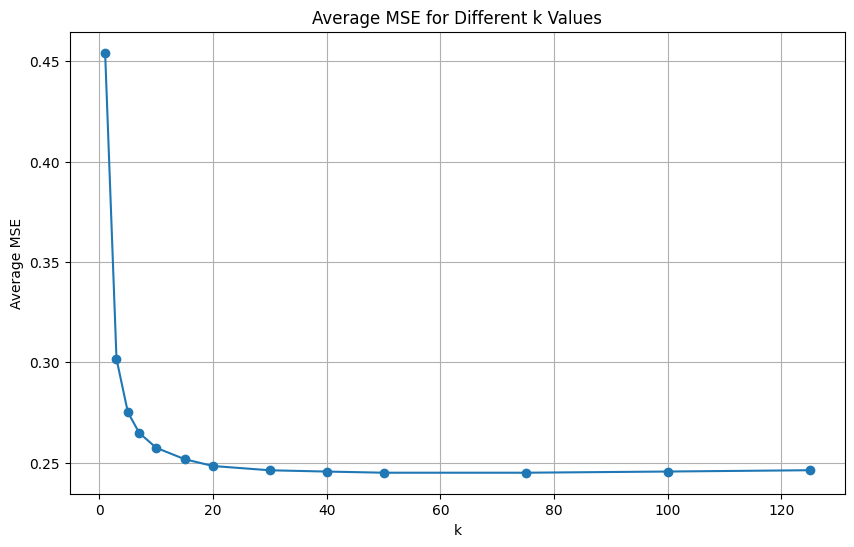

In [9]:
# Plot MSE for different k values
plt.figure(figsize=(10, 6))
plt.plot(K_VALUES, average_errors, marker='o')
plt.xlabel('k')
plt.ylabel('Average MSE')
plt.title('Average MSE for Different k Values')
plt.grid(True)
plt.show()

## KNN - Perform KNN to fill in missing ratings based on best 'k'

In [10]:
# Compute cosine similarity matrix between all embeddings
similarity_matrix = cosine_similarity(embeddings)

In [11]:
def predict_rating(idx, k=best_k):
    """Computes the weighted average ratings for a null'd manga based on manga
    that are similar synopsis wise
    
    EXPLANATION for weighted average - 
    Multiply ratings by corresponding similarity scores then sums those products then divide by similarity score sum so we normalize the value
    
    Leverages the idea that manga with more similar synopsis should have a greater influence on the predicted ratings
    

    Args:
        idx (int): row index on dataframe
        k (int, optional): top k similar synposis. Defaults to 5.

    Returns:
        float: final rating for that manga without a rating
    """
    # Get the similarity scores for the target manga
    sim_scores = similarity_matrix[idx]
    
    # Get indices of k most similar manga with non-null ratings
    similar_indices = np.argsort(sim_scores)[::-1]
    similar_indices = [i for i in similar_indices if not pd.isnull(ratings[i])][:k]
    
    if not similar_indices:
        return np.nan  # If there are no similar rated manga, return NaN
    similar_ratings = ratings[similar_indices]
    similar_scores = sim_scores[similar_indices]
    
    # Compute the weighted average of the ratings
    return np.dot(similar_ratings, similar_scores) / similar_scores.sum()

In [12]:
# Predict and fill missing ratings
for idx, rating in enumerate(ratings):
    if pd.isnull(rating):
        ratings[idx] = predict_rating(idx)

# Update the dataframe
df['score'] = ratings

In [13]:
df.isnull().sum()

title           0
type            0
score           0
genres          0
themes          0
demographics    0
authors         0
synopsis        0
background      0
url             0
dtype: int64

In [14]:
# Save the updated dataframe to a new CSV file
df.to_csv('../data/processed/manga_cleaned_' + MODEL + '.csv', index=False)